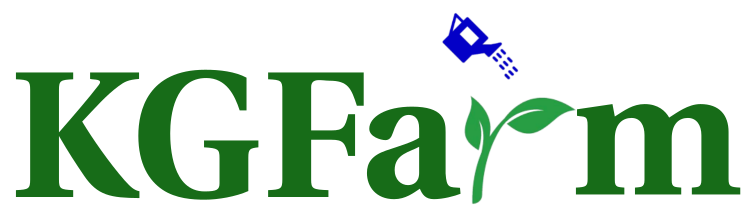
<br/>**A Feature Discovery System for Data Science Across the Enterprise**

## **A practical usecase**

**Machine Learning task** - **<font color='green'>Earthquake</font> <font color='green'>magnitude</font> prediction**

In [1]:
from operations.api import KGFarm
kgfarm = KGFarm()

(KGFarm is running in Human in the loop mode)
Connected to Stardog!
Access the Stardog UI at: https://cloud.stardog.com/


#### Feature identification

In [2]:
feature_info = kgfarm.identify_features(entity='earthquake', target='magnitude')
feature_info

,Entity,Physical_representation,Features,Feature_view,Physical_table,Number_of_rows,File_source
0,Earthquake,earthquake_id,"[horizontal_error, depth, gap, populated, mag_error, depth_error, d_min]",Feature view 2,seismic_activity.csv,11490,/Users/shubhamvashisth/Desktop/data_lake/earthquake/data/seismic_activity.csv


In [3]:
import pandas as pd

entity_df = pd.read_csv(feature_info.iloc[0].File_source)
print(feature_info.iloc[0].Physical_table)
entity_df

seismic_activity.csv


,event_timestamp,earthquake_id,d_min,mag_error,depth,depth_error,horizontal_error,gap,populated,magnitude
0,2023-03-13 02:22:56.130,ci40184031,0.045690,0.216000,15.520,0.530,0.37,68.0,dense,0.68
1,2023-03-13 02:13:53.366,us7000jjg2,0.692000,0.083000,10.000,1.892,4.20,59.0,sparse,4.40
2,2023-03-13 02:04:10.571,us7000jjg1,0.199000,0.066000,8.987,0.878,1.46,63.0,sparse,2.60
3,2023-03-13 02:02:34.403,ak0233b3wcuo,NaN,NaN,40.300,0.700,NaN,NaN,dense,1.50
4,2023-03-13 02:00:07.010,ci40184023,0.067100,0.166000,14.730,0.870,0.56,79.0,dense,0.59
...,...,...,...,...,...,...,...,...,...,...
11485,2023-02-11 02:48:57.101,ak0231xi1y2x,NaN,NaN,126.100,0.500,NaN,NaN,sparse,1.70
11486,2023-02-11 02:48:27.287,ak0231xi1sfc,NaN,NaN,106.300,0.700,NaN,NaN,sparse,2.00
11487,2023-02-11 02:47:47.830,nc73844821,0.009504,0.242000,1.060,0.930,0.32,69.0,sparse,0.42
11488,2023-02-11 02:47:33.530,nc73844816,0.009960,0.249000,1.050,0.250,0.16,37.0,sparse,1.50


**Data enrichment**

<code>kgfarm.search_enrichment_options()</code> returns set of tables / <code>entity_df</code> and the corresponding Feature view that could be used in order to enrich them with fresh set of features.
  *   <b><code>Joinability_strength</code></b> represents how much a given table / <code>entity_df</code> and a Feature view are joinable. 
  * <b> You can also pass your <code>entity_df</code> to <code>kgfarm.search_enrichment_options(entity_df: pd.Dataframe)</code> to get the corresponding Feature view that could be used for feature enrichment.</b>

In [4]:
enrichment_info = kgfarm.search_enrichment_options(entity_df)
enrichment_info

Searching for enrichment options: 100%|██████████| 2/2 [00:00<00:00, 61.95it/s]


,Enrich_with,Physical_joinable_table,Join_key,Joinability_strength,File_source
0,Feature view 1,earthquake_stats.csv,earthquake_id,100%,/Users/shubhamvashisth/Desktop/data_lake/earthquake/data/earthquake_stats.csv


**Enriching data with point-in-time correct joins**

KGFarm can join features from a feature view to an entity dataframe in a <b>point-in-time correct way</b> i.e. KGFarm can retrieve values at a specific points in time.
KGFarm scans backward in time from the entity dataframe timestamp up to a maximum of the <code>freshness</code>  (parameter passed by user) 

<code>kgfarm.enrich()</code> takes the following as input:<br>
   1. Feature view metadeta from <code>kgfarm.search_enrichment_options()</code>
   2. <code>entity_df</code> that needs to be enriched and
   3. <code>freshness</code> defines the feature freshness time-window (in days) and returns an enriched set of features joined in point-in-time correct manner.

In [5]:
entity_df = kgfarm.enrich(enrichment_info.iloc[0], entity_df, freshness=10)
entity_df

Enriching entity_df with 8 feature(s) ['type', 'residual_rms', 'latitude', 'mag_type', 'mag_source', 'mag_nst', 'nst', 'longitude']


Enriching: 100%|██████████| 13788/13788 [00:07<00:00, 1786.15it/s]


,event_timestamp,earthquake_id,d_min,mag_error,depth,depth_error,horizontal_error,gap,populated,type,residual_rms,latitude,mag_type,mag_source,mag_nst,nst,longitude,magnitude
0,2023-02-11 02:44:21.300,pr71395898,0.606300,0.016683,20.800,13.930,0.84,273.0,sparse,earthquake,0.18,19.079167,md,pr,7.0,15.0,-66.429333,3.20
1,2023-02-11 02:47:33.530,nc73844816,0.009960,0.249000,1.050,0.250,0.16,37.0,sparse,earthquake,0.06,38.778833,md,nc,37.0,44.0,-122.758333,1.50
2,2023-02-11 02:47:47.830,nc73844821,0.009504,0.242000,1.060,0.930,0.32,69.0,sparse,earthquake,0.05,38.777833,md,nc,11.0,13.0,-122.757667,0.42
3,2023-02-11 02:48:27.287,ak0231xi1sfc,NaN,NaN,106.300,0.700,NaN,NaN,sparse,earthquake,0.45,59.670000,ml,ak,NaN,NaN,-153.317800,2.00
4,2023-02-11 02:48:57.101,ak0231xi1y2x,NaN,NaN,126.100,0.500,NaN,NaN,sparse,earthquake,0.42,63.167800,ml,ak,NaN,NaN,-150.783100,1.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9388,2023-03-13 02:02:34.403,ak0233b3wcuo,NaN,NaN,40.300,0.700,NaN,NaN,dense,earthquake,0.85,60.053200,ml,ak,NaN,NaN,-152.572100,1.50
9389,2023-03-13 02:04:10.571,us7000jjg1,0.199000,0.066000,8.987,0.878,1.46,63.0,sparse,earthquake,0.49,31.596400,ml,us,46.0,28.0,-104.283700,2.60
9390,2023-03-13 02:13:53.366,us7000jjg2,0.692000,0.083000,10.000,1.892,4.20,59.0,sparse,earthquake,0.92,38.126500,mb,us,42.0,67.0,38.694500,4.40
9391,2023-03-13 02:13:53.366,us7000jjg2,0.692000,0.083000,10.000,1.892,4.20,59.0,sparse,earthquake,0.92,38.126500,mb,us,42.0,67.0,38.694500,4.40


**Recommending data cleaning operations**

Scanning missing values


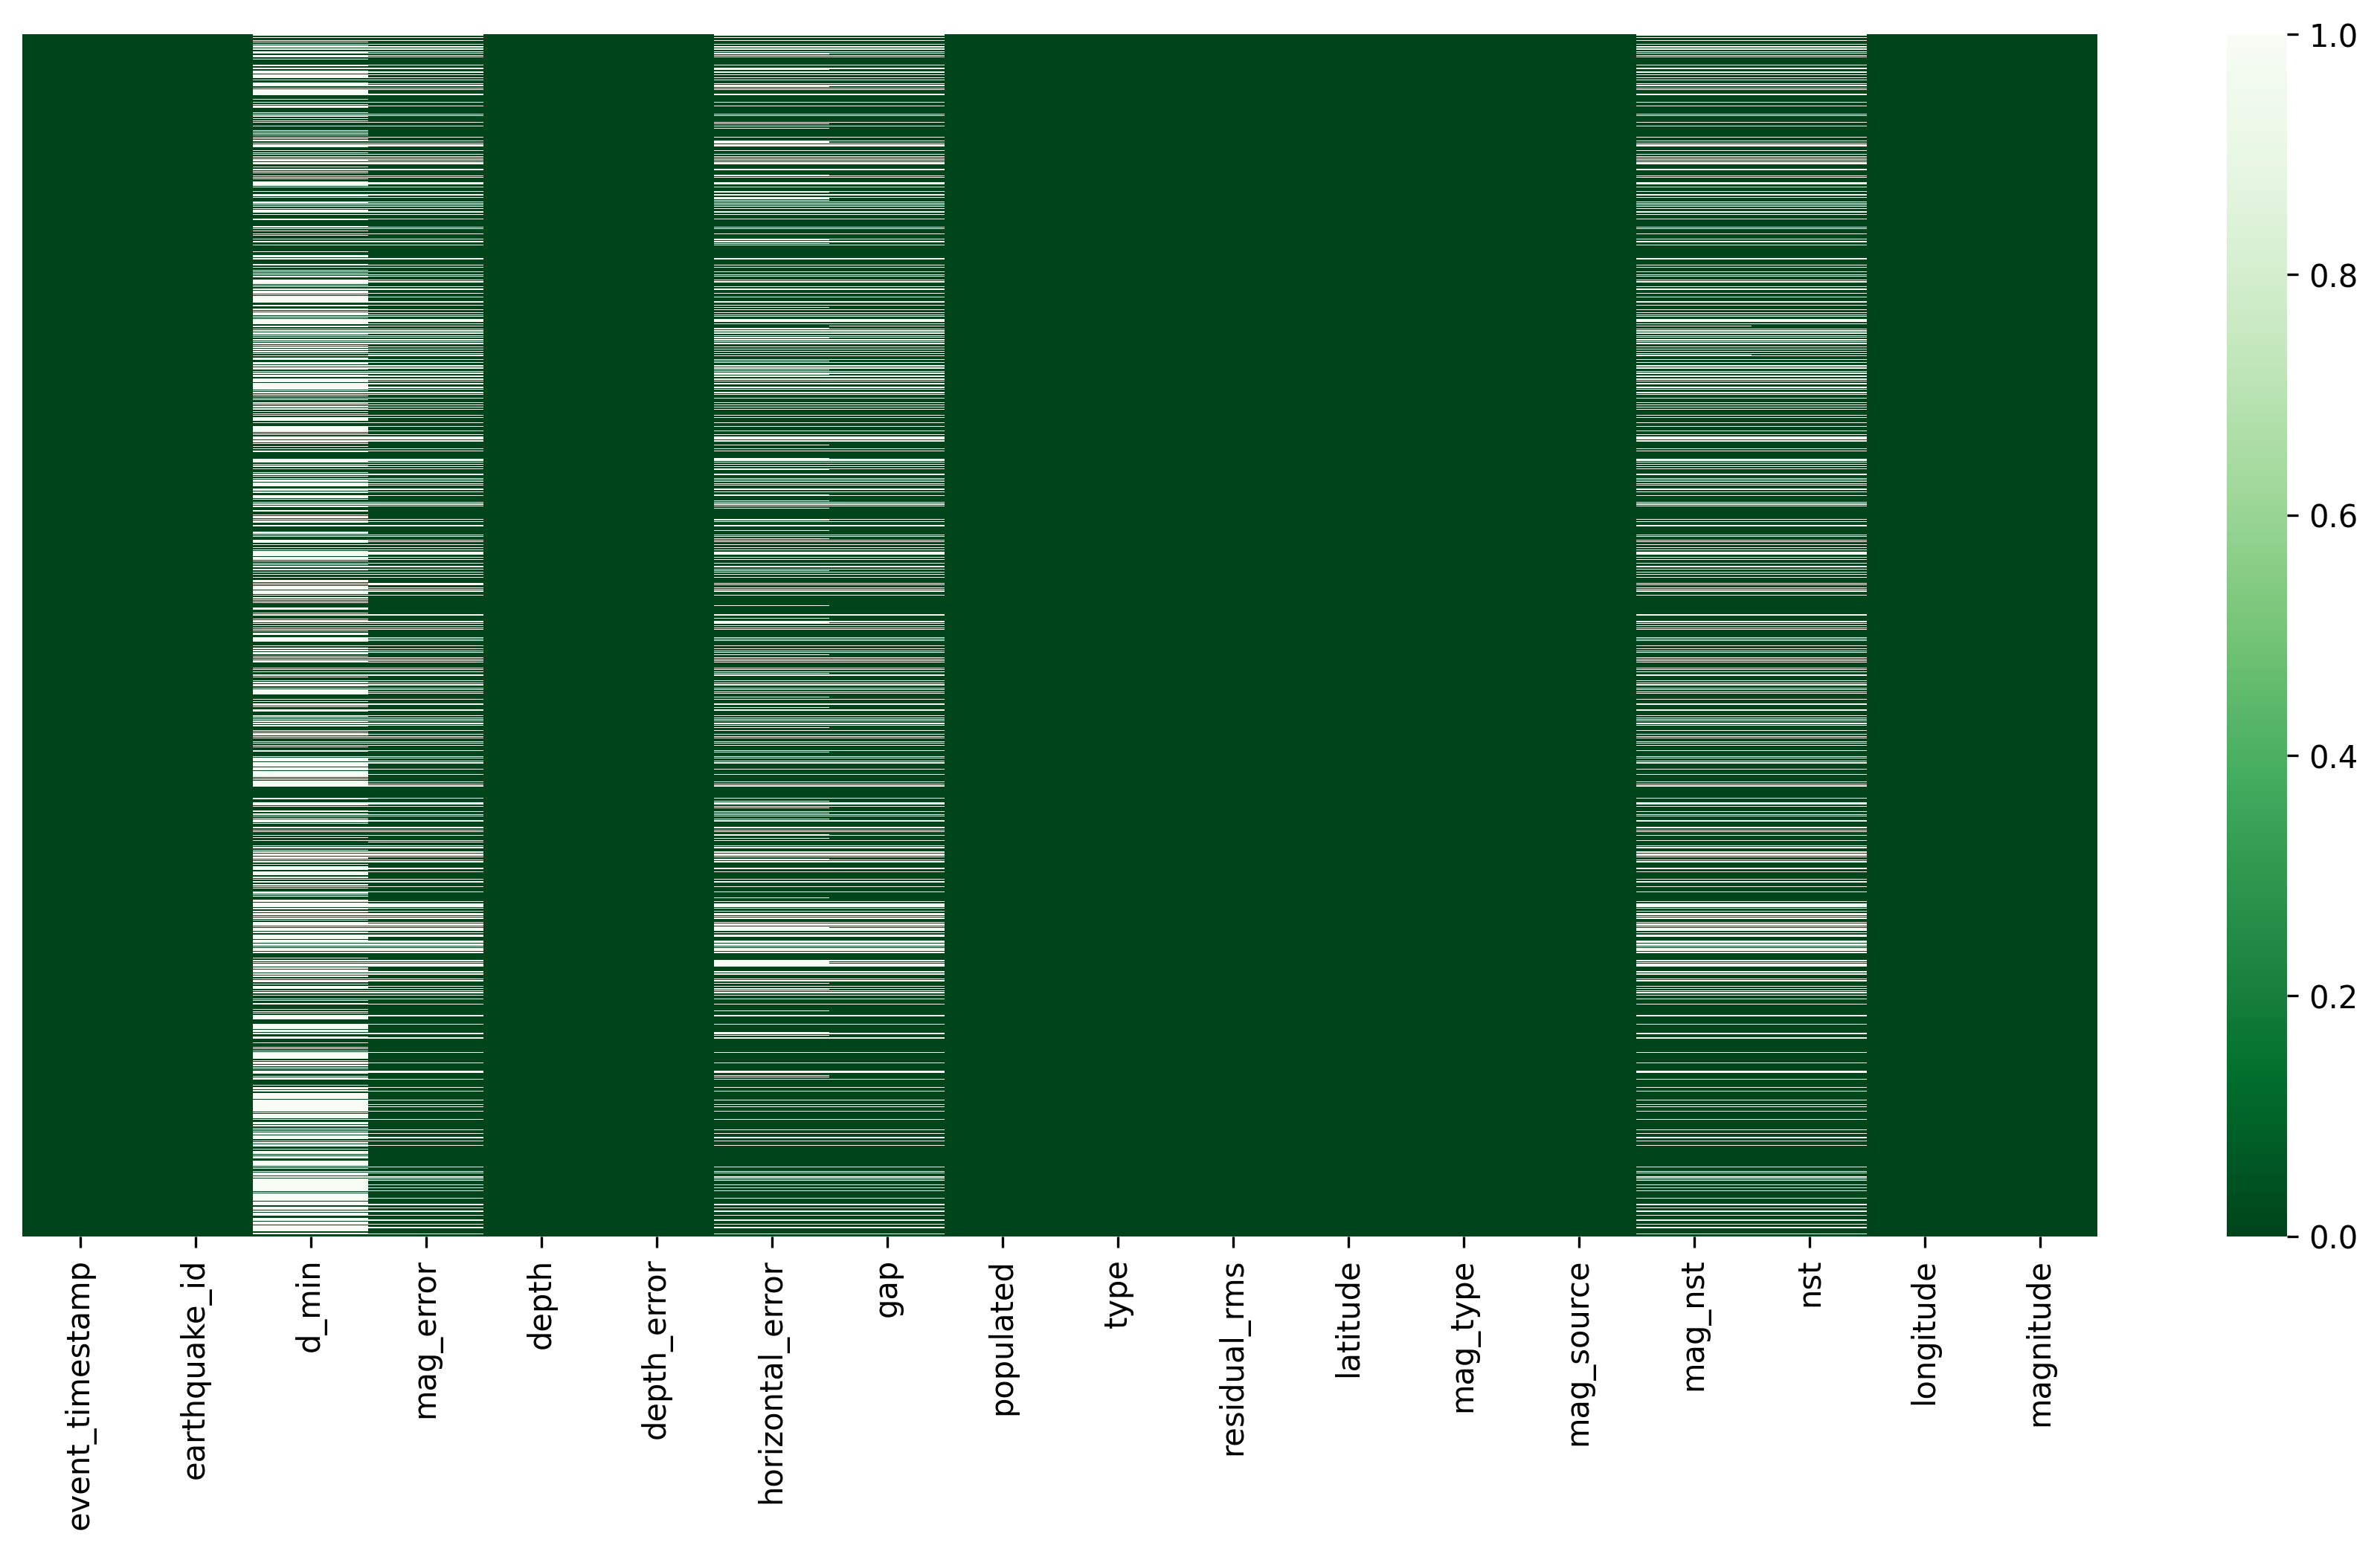

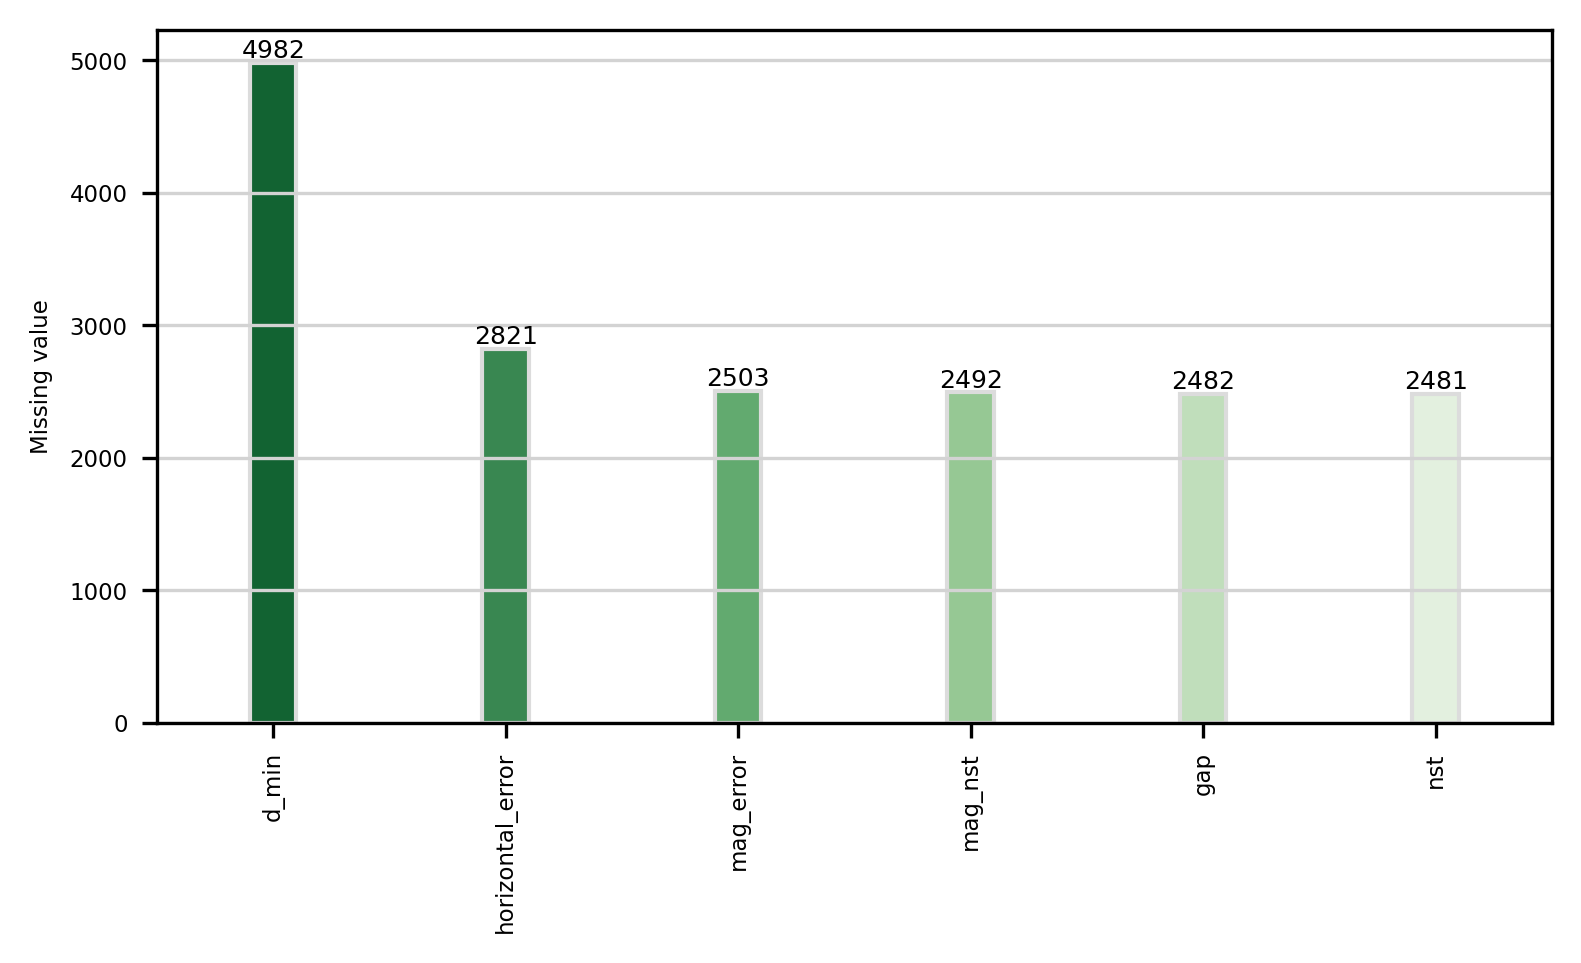

,Operation,Feature,Parameters,Pipeline
0,Interpolate,"[d_min, horizontal_error, mag_error, mag_nst, gap, nst]",{'method': 'ffill'},data cleaning


In [6]:
cleaning_info = kgfarm.recommend_cleaning_operations(entity_df)
cleaning_info

In [7]:
entity_df = kgfarm.clean(entity_df, cleaning_info.iloc[0])
entity_df

interpolated missing values for ['d_min', 'horizontal_error', 'mag_error', 'mag_nst', 'gap', 'nst'] feature(s)

all features look clean


,event_timestamp,earthquake_id,d_min,mag_error,depth,depth_error,horizontal_error,gap,populated,type,residual_rms,latitude,mag_type,mag_source,mag_nst,nst,longitude,magnitude
0,2023-02-11 02:44:21.300,pr71395898,0.606300,0.016683,20.800,13.930,0.84,273.0,sparse,earthquake,0.18,19.079167,md,pr,7.0,15.0,-66.429333,3.20
1,2023-02-11 02:47:33.530,nc73844816,0.009960,0.249000,1.050,0.250,0.16,37.0,sparse,earthquake,0.06,38.778833,md,nc,37.0,44.0,-122.758333,1.50
2,2023-02-11 02:47:47.830,nc73844821,0.009504,0.242000,1.060,0.930,0.32,69.0,sparse,earthquake,0.05,38.777833,md,nc,11.0,13.0,-122.757667,0.42
3,2023-02-11 02:48:27.287,ak0231xi1sfc,0.009504,0.242000,106.300,0.700,0.32,69.0,sparse,earthquake,0.45,59.670000,ml,ak,11.0,13.0,-153.317800,2.00
4,2023-02-11 02:48:57.101,ak0231xi1y2x,0.009504,0.242000,126.100,0.500,0.32,69.0,sparse,earthquake,0.42,63.167800,ml,ak,11.0,13.0,-150.783100,1.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9388,2023-03-13 02:02:34.403,ak0233b3wcuo,0.067100,0.166000,40.300,0.700,0.56,79.0,dense,earthquake,0.85,60.053200,ml,ak,8.0,14.0,-152.572100,1.50
9389,2023-03-13 02:04:10.571,us7000jjg1,0.199000,0.066000,8.987,0.878,1.46,63.0,sparse,earthquake,0.49,31.596400,ml,us,46.0,28.0,-104.283700,2.60
9390,2023-03-13 02:13:53.366,us7000jjg2,0.692000,0.083000,10.000,1.892,4.20,59.0,sparse,earthquake,0.92,38.126500,mb,us,42.0,67.0,38.694500,4.40
9391,2023-03-13 02:13:53.366,us7000jjg2,0.692000,0.083000,10.000,1.892,4.20,59.0,sparse,earthquake,0.92,38.126500,mb,us,42.0,67.0,38.694500,4.40


**Recommending data transformations**

In [16]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
entity_df[['mag_source', 'mag_type', 'type', 'populated']] = encoder.fit_transform(entity_df[['mag_source', 'mag_type', 'type', 'populated']])
entity_df

,event_timestamp,earthquake_id,d_min,mag_error,depth,depth_error,horizontal_error,gap,populated,type,residual_rms,latitude,mag_type,mag_source,mag_nst,nst,longitude,magnitude
0,2023-02-11 02:44:21.300,pr71395898,0.606300,0.016683,20.800,13.930,0.84,273.0,1.0,0.0,0.18,19.079167,2.0,9.0,7.0,15.0,-66.429333,3.20
1,2023-02-11 02:47:33.530,nc73844816,0.009960,0.249000,1.050,0.250,0.16,37.0,1.0,0.0,0.06,38.778833,2.0,5.0,37.0,44.0,-122.758333,1.50
2,2023-02-11 02:47:47.830,nc73844821,0.009504,0.242000,1.060,0.930,0.32,69.0,1.0,0.0,0.05,38.777833,2.0,5.0,11.0,13.0,-122.757667,0.42
3,2023-02-11 02:48:27.287,ak0231xi1sfc,0.009504,0.242000,106.300,0.700,0.32,69.0,1.0,0.0,0.45,59.670000,4.0,0.0,11.0,13.0,-153.317800,2.00
4,2023-02-11 02:48:57.101,ak0231xi1y2x,0.009504,0.242000,126.100,0.500,0.32,69.0,1.0,0.0,0.42,63.167800,4.0,0.0,11.0,13.0,-150.783100,1.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9388,2023-03-13 02:02:34.403,ak0233b3wcuo,0.067100,0.166000,40.300,0.700,0.56,79.0,0.0,0.0,0.85,60.053200,4.0,0.0,8.0,14.0,-152.572100,1.50
9389,2023-03-13 02:04:10.571,us7000jjg1,0.199000,0.066000,8.987,0.878,1.46,63.0,1.0,0.0,0.49,31.596400,4.0,12.0,46.0,28.0,-104.283700,2.60
9390,2023-03-13 02:13:53.366,us7000jjg2,0.692000,0.083000,10.000,1.892,4.20,59.0,1.0,0.0,0.92,38.126500,0.0,12.0,42.0,67.0,38.694500,4.40
9391,2023-03-13 02:13:53.366,us7000jjg2,0.692000,0.083000,10.000,1.892,4.20,59.0,1.0,0.0,0.92,38.126500,0.0,12.0,42.0,67.0,38.694500,4.40


In [17]:
dependent_variable = 'magnitude'
independent_variable = [feature for feature in entity_df.columns if feature != dependent_variable]
X = entity_df[independent_variable]
y = entity_df[dependent_variable]

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

In [21]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

# instanciate the models
random_forest_regressor = RandomForestRegressor()
gradient_boosting_regressor = GradientBoostingRegressor()
support_vector_regressor = SVR()

# fit the models on data
random_forest_regressor.fit(X_train, y_train)
gradient_boosting_regressor.fit(X_train, y_train)
support_vector_regressor.fit(X_train, y_train)

# evaluate model performance
y_pred = random_forest_regressor.predict(X_test)
r2_random_forest_regressor = round(r2_score(y_test, y_pred), 3)
y_pred = gradient_boosting_regressor.predict(X_test)
r2_gradient_boosting_regressor = round(r2_score(y_test, y_pred), 3)
y_pred = support_vector_regressor.predict(X_test)
r2_support_vector_regressor= round(r2_score(y_test, y_pred), 3)

In [22]:
print(r2_random_forest_regressor)
print(r2_gradient_boosting_regressor)
print(r2_support_vector_regressor)

0.933
0.903
0.782
